In [206]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp
from numpy import pi as pi

In [239]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

mu=1.8
m=.5
t=3
alR=.7
B=1.5
delta=.5
phi=np.pi*1.75

def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
def kF(mu):
    return cmath.sqrt(2*m*mu)
def a(t):
    return 1/cmath.sqrt(2*m*t)

def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
def nu0(m):
    return m/(2*np.pi)
def xiE(En):
    return kF(mu)/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL

NJ=3

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [240]:
#Junction
def HJ0(kx):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
def Hy(alR):
    return -t*t3+1j*alR/2/a(t)*np.kron(s3,s1)


def HJ(kx):
    start=cmm(HJ0(kx))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy(alR))])
        CT=sp.hstack([OT.transpose(),cmm(Hy(alR).conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx):
    return En*np.eye(4*NJ)-HJ(kx).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(mu)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)-kx))))-1j

def gSC1m1(En,kx):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx):
    return scipy.linalg.block_diag(gSC1m1(En,kx),gJm1(En,kx),gSC2m1(En,kx))+mHt.toarray()

In [241]:
Barray=np.ndarray.tolist(np.linspace(0.5,2,15))
NM=len(Barray)

L=75 #E decimation
Earray=np.linspace(0.5,0.,L+1)-0.00001
Nroots=30
EJdisp=np.zeros([L+1,Nroots])

SpecBvar=np.zeros((NM,np.shape(EJdisp)[0],np.shape(EJdisp)[1]))

for sb in range(NM):
    B=Barray[sb]             #change variable here
    print('{})B={}'.format(sb,B))             #change variable here
    for j in range(L+1):
        print(j)
        ekx=[]
        En=Earray[j]
        def fdet(kx):
            return np.linalg.det(Gtotm1(En,kx))/(mu**(8*(NJ+2)))
        #jtmm=[-5+0.1*opq for opq in range(51)]
        x0roots=np.ndarray.tolist(np.linspace(-3.14,0.,np.int(np.pi/0.2)))
        #x0roots.extend(jtmm)
        for i in range(len(x0roots)):
            x0=x0roots[i]
            solekx=opt.fsolve(fdet,np.asarray(x0))
            if abs(fdet(solekx))>10**(-6) or abs(solekx)>np.pi or solekx>0:
                solekx=[]
            solekx=np.ndarray.tolist(np.around(solekx,4))
            ekx.extend(solekx)
        ekx=list(set(ekx))
        print(ekx)
        if len(ekx)<Nroots:
            zerocompletion=[-np.pi]*(Nroots-len(ekx))
            ekx.extend(zerocompletion)
        elif len(ekx)>Nroots:
            print('More than {} roots.'.format(Nroots))
            break
        EJdisp[j]=np.asarray(ekx)
    SpecBvar[sb]=EJdisp

0)B=0.5
0
[-1.421, -1.3872, -1.6958]
1
[-1.3719, -1.4138, -1.6953]
2
[-1.3108, -1.3379, -1.6935, -1.4053]
3
[-1.3952, -1.6915, -0.4415, -1.2656]
4
[-1.382, -1.6893, -1.3054]
5
[-1.6871, -1.3489]
6
[-1.6848]
7
[-1.6824]
8
[-1.68]
9
[-1.6775]
10
[-1.675]
11
[-1.6724]
12
[-1.6698]
13
[-1.6672]
14
[-1.6646]
15
[-1.6619]
16
[-1.6591]
17
[-1.6563]
18
[-1.6535]
19
[-1.6506]
20
[-1.6477]
21
[-1.6448]
22
[-1.6418]
23
[-1.6387]
24
[-1.6356]
25
[-1.0982, -0.9546, -1.6324]
26
[-0.7742, -1.184, -1.6291]
27
[-1.2245, -0.6248, -1.6258]
28
[-1.6224, -1.2537, -0.4586]
29
[-1.6189, -0.2076, -1.2781]
30
[-1.3007, -1.6152]
31
[-1.3241, -1.6115]
32
[-1.3526, -1.6076]
33
[-1.6036, -1.3946]
34
[-1.4249, -1.5993]
35
[-1.5948, -1.4422]
36
[-1.4552, -1.59]
37
[-1.4665, -1.5848]
38
[-1.579]
39
[-1.5724]
40
[-1.5645]
41
[-1.5534]
42
[]
43
[]
44
[]
45
[]
46
[]
47
[]
48
[]
49
[]
50
[]
51
[]
52
[]
53
[]
54
[]
55
[]
56
[]
57
[]
58
[]
59
[]
60
[]
61
[]
62
[]
63
[]
64
[]
65
[]
66
[]
67
[]
68
[]
69
[]
70
[]
71
[]
72
[]


[-1.718]
29
[-1.7156]
30
[-1.7131]
31
[-1.7106]
32
[-1.7081]
33
[-1.7056]
34
[-1.703]
35
[-1.7004]
36
[-1.6978]
37
[-1.6951]
38
[-1.4467, -1.6924, -1.4891]
39
[-1.5014, -1.4319, -1.6896]
40
[-1.4203, -1.5104, -1.6869]
41
[-1.684, -1.5179, -1.4098]
42
[-1.3998, -1.6811, -1.5245]
43
[-1.5306, -1.3898, -1.6782]
44
[-1.3796, -1.5363, -1.6751]
45
[-1.5418, -1.3687, -1.672]
46
[-1.5472, -1.3567, -1.6688]
47
[-1.6655, -1.3427, -1.5524]
48
[-1.3245, -1.6621, -1.5575]
49
[-1.6584, -1.2914, -0.936, -1.5627, -1.2239]
50
[-0.8431, -1.6546, -1.5679]
51
[-1.6505, -0.7621, -1.5734]
52
[-1.5791, -1.646, -0.6841]
53
[-1.6409, -0.6051, -1.5853]
54
[-0.522, -1.6347, -1.5925]
55
[-0.4302, -1.6258]
56
[-0.3209]
57
[-0.159]
58
[]
59
[]
60
[]
61
[]
62
[]
63
[]
64
[]
65
[]
66
[]
67
[]
68
[]
69
[]
70
[]
71
[]
72
[]
73
[]
74
[]
75
[]
8)B=1.35714285714
0
[-1.7896, -1.4493]
1
[-1.7896, -1.4447]
2
[-1.7883, -1.4395]
3
[-1.434, -1.7867]
4
[-1.785, -1.4281]
5
[-1.7832, -1.422]
6
[-1.7813, -1.4154]
7
[-1.4082, -1.779

[-1.7568, -1.3172]
49
[-1.3074, -1.7543]
50
[-1.2967, -1.7517]
51
[-1.7491, -1.2847]
52
[-1.271, -1.7464]
53
[-1.2548, -1.7437]
54
[-1.2351, -1.7409]
55
[-1.7379, -1.2098]
56
[-1.1754, -1.7349]
57
[-1.1272, -1.7316]
58
[-1.7281, -1.0646]
59
[-1.7242, -0.9955]
60
[-0.9265, -1.7197]
61
[-1.7135, -0.8594]
62
[-0.7939]
63
[-0.7297]
64
[-0.6663]
65
[-0.6035]
66
[-0.541]
67
[-0.4787]
68
[-0.4165]
69
[-0.354]
70
[-0.2911]
71
[-0.2273]
72
[-0.1611]
73
[-0.0874]
74
[]
75
[]
13)B=1.89285714286
0
[-1.869, -1.4694]
1
[-1.4653, -1.8692]
2
[-1.8681, -1.4607]
3
[-1.456, -1.8667]
4
[-1.4512, -1.8652]
5
[-1.8636, -1.4462]
6
[-1.8619, -1.4412]
7
[-1.8602, -1.4359]
8
[-1.4305, -1.8585]
9
[-1.4248, -1.8567]
10
[-1.419, -1.8549]
11
[-1.4128, -1.8531]
12
[-1.4063, -1.8513]
13
[-1.3993, -1.8494]
14
[-1.3918, -0.4317, -1.8476, -0.882]
15
[-1.3834, -1.0569, -1.8457]
16
[-1.8438, -1.1323, -1.374]
17
[-1.1832, -1.3629, -1.8418, -1.547]
18
[-1.5559, -1.8399, -1.2248, -1.3485]
19
[-1.3244, -1.5627, -1.2688, -1.837

In [242]:
SpecBvarOfTheFollowingGraphs5=SpecBvar

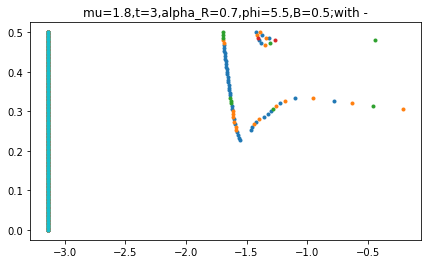

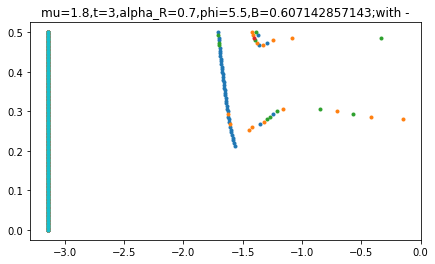

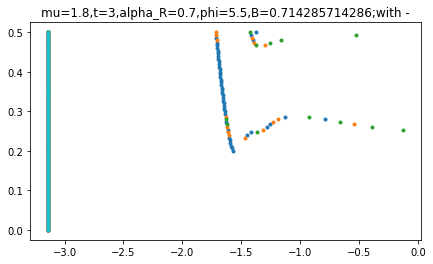

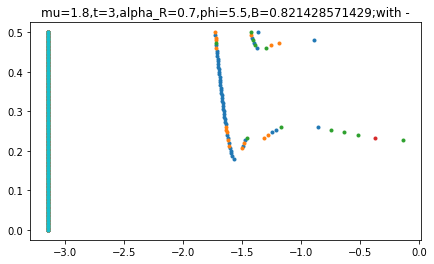

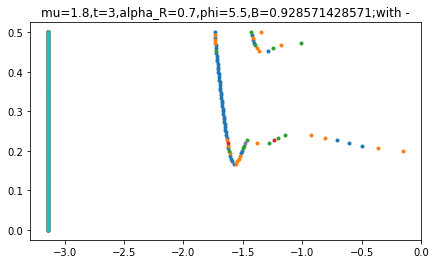

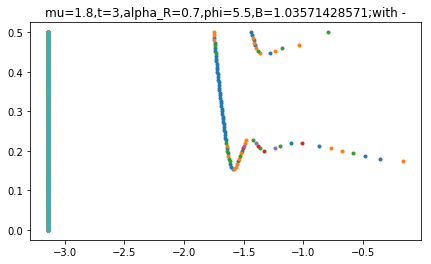

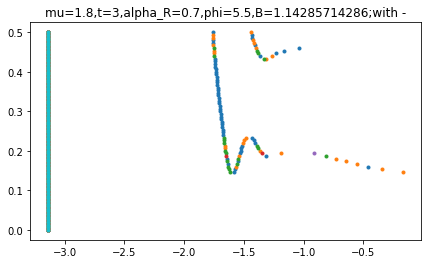

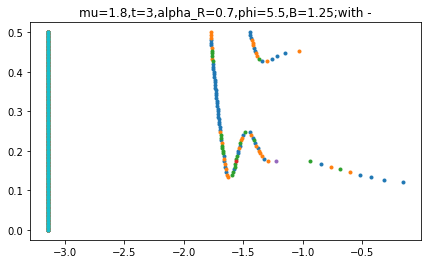

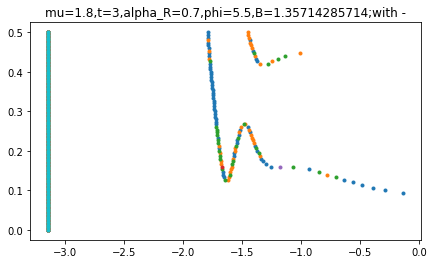

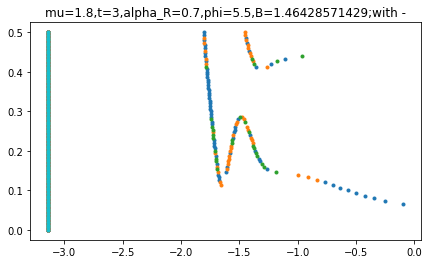

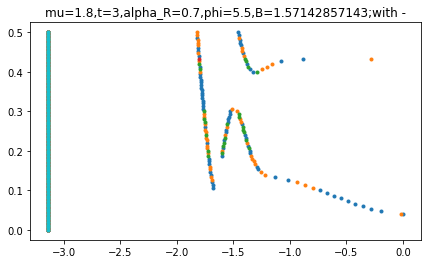

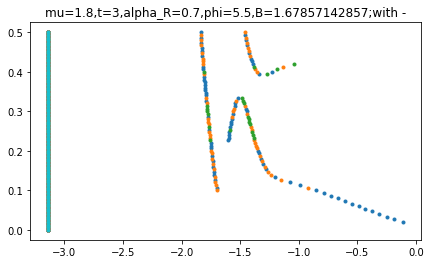

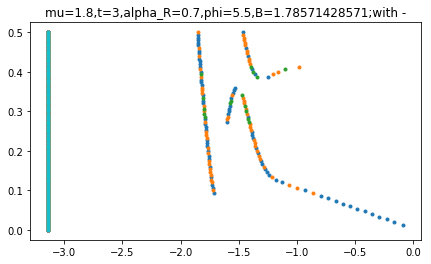

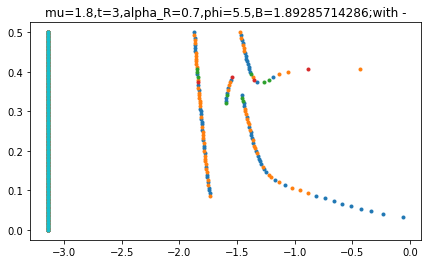

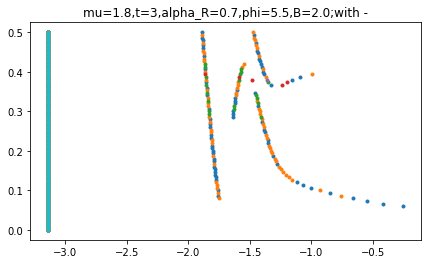

In [244]:
for l in range(len(SpecBvarOfTheFollowingGraphs5)):
    EJdisp=SpecBvarOfTheFollowingGraphs5[l]
    pp.figure(figsize=(7,4))
    for p in range(len(EJdisp[1])):
        pp.plot(EJdisp[:,p],Earray,'.')
    #pp.axis([-1.7,-1.35,-delta-0.1,delta+0.1])
    pp.title('mu={},t={},alpha_R={},phi={},B={};with -'.format(mu,t,alR,round(phi,2),Barray[l]))

SpecBvarOfTheFollowingGraphs4=SpecBvar

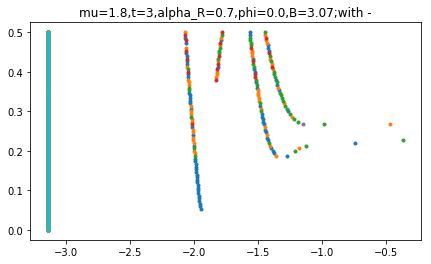

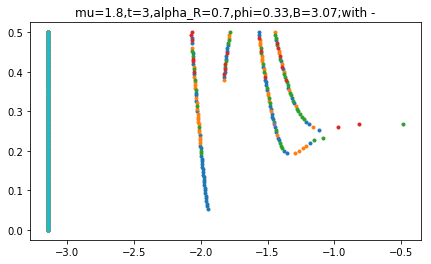

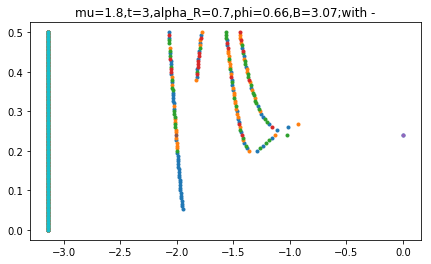

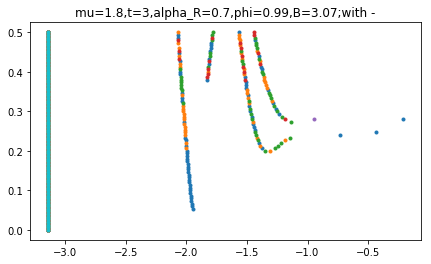

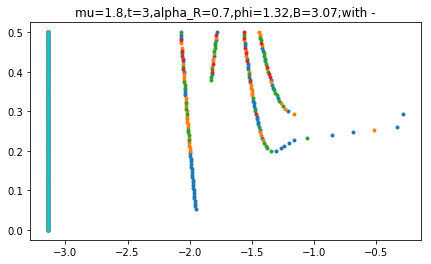

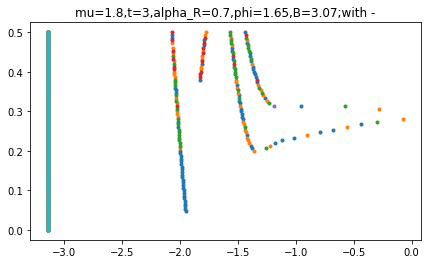

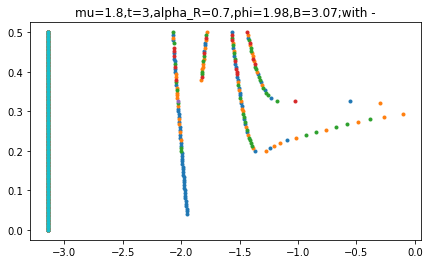

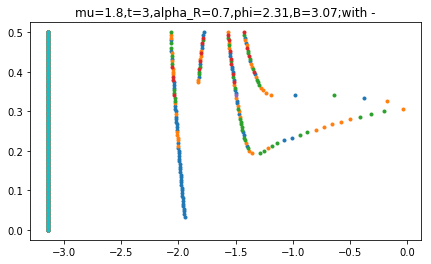

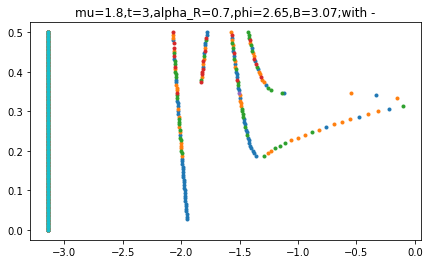

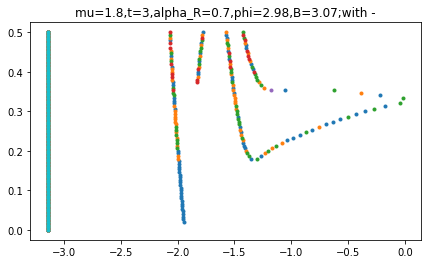

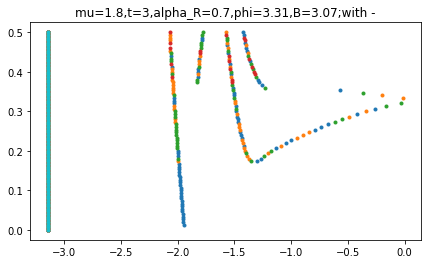

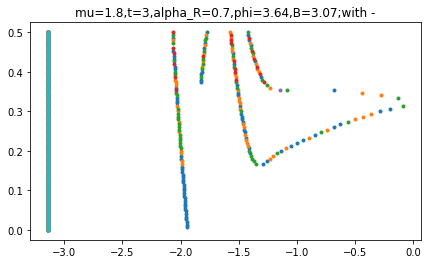

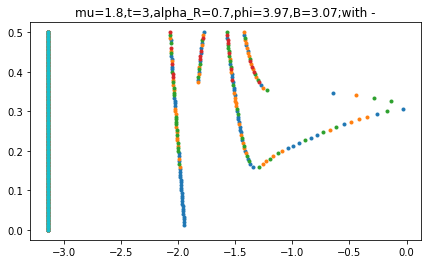

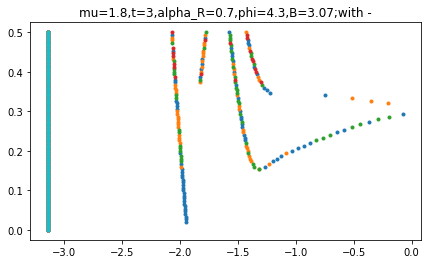

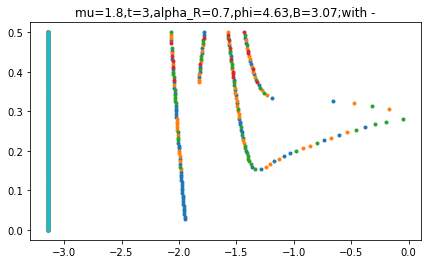

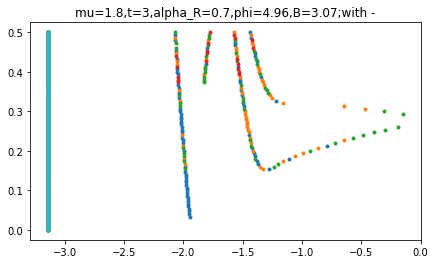

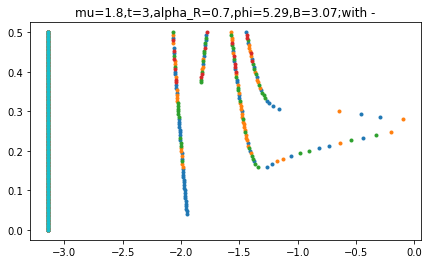

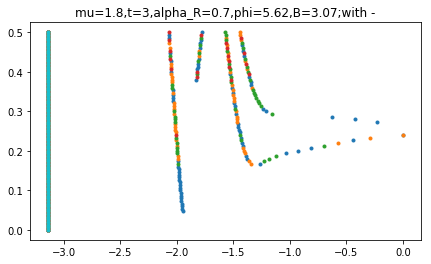

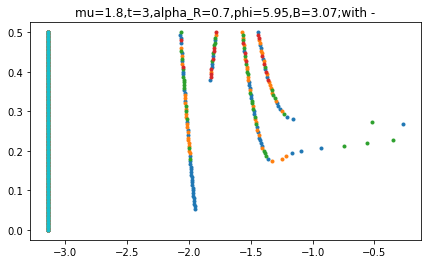

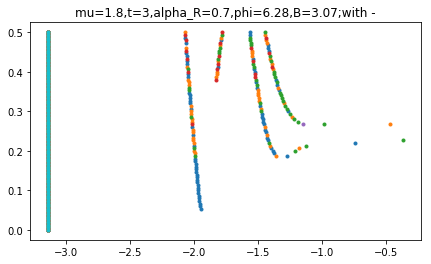

In [231]:
for l in range(len(SpecBvarOfTheFollowingGraphs4)):
    EJdisp=SpecBvarOfTheFollowingGraphs4[l]
    pp.figure(figsize=(7,4))
    for p in range(len(EJdisp[1])):
        pp.plot(EJdisp[:,p],Earray,'.')
    #pp.axis([-1.7,-1.35,-delta-0.1,delta+0.1])
    pp.title('mu={},t={},alpha_R={},phi={},B={};with -'.format(mu,t,alR,round(Barray[l],2),B))

SpecBvarOfTheFollowingGraphs3=SpecBvar

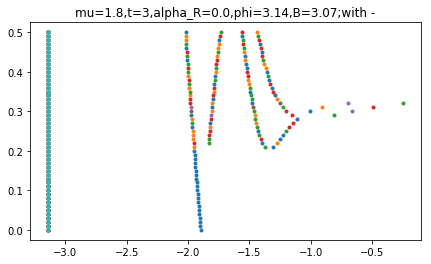

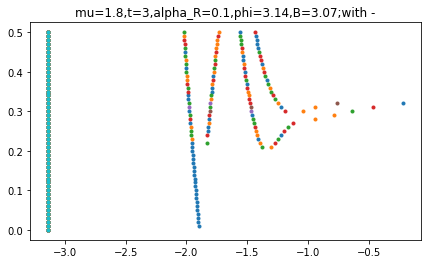

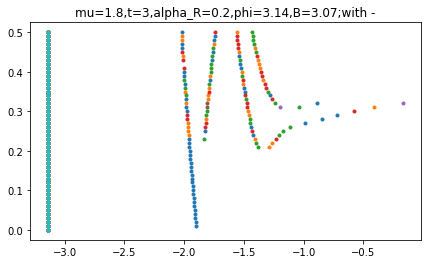

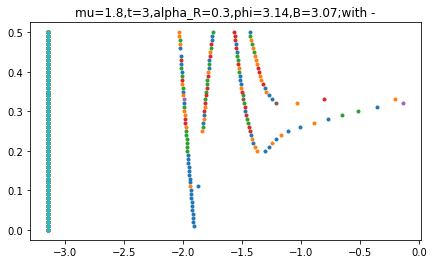

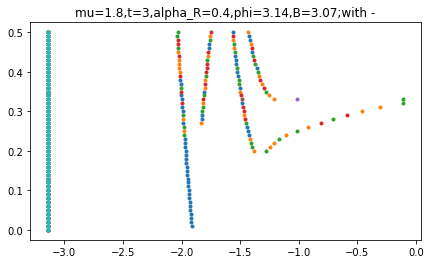

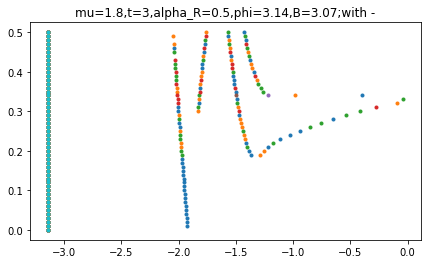

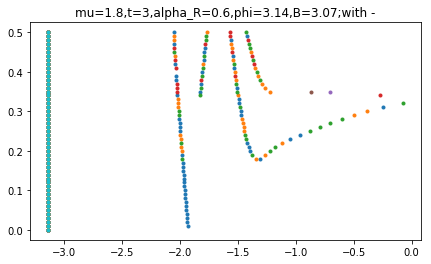

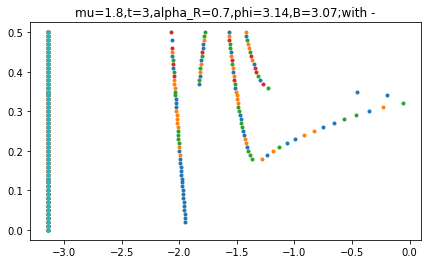

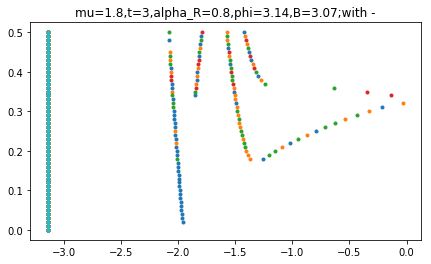

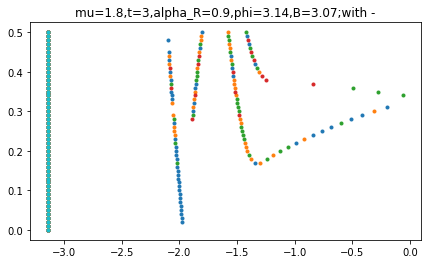

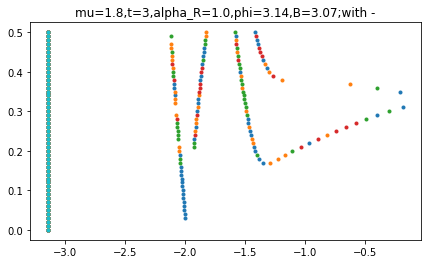

In [212]:
#don't touch this cell
for l in range(len(SpecBvar)):
    EJdisp=SpecBvar[l]
    pp.figure(figsize=(7,4))
    for p in range(len(EJdisp[1])):
        pp.plot(EJdisp[:,p],Earray,'.')
    #pp.axis([-1.7,-1.35,-delta-0.1,delta+0.1])
    pp.title('mu={},t={},alpha_R={},phi={},B={};with -'.format(mu,t,Barray[l],round(phi,2),B))

SpecBvarOfTheFollowingGraphs2=SpecBvar

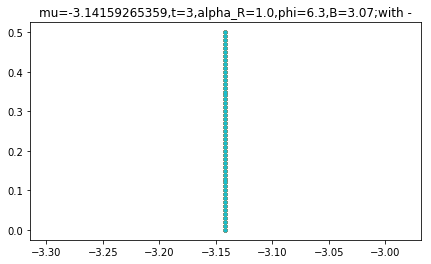

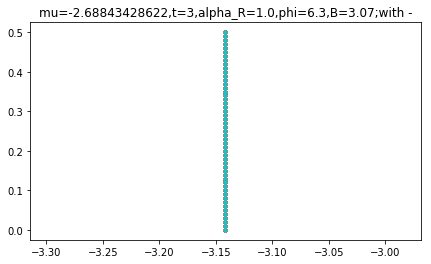

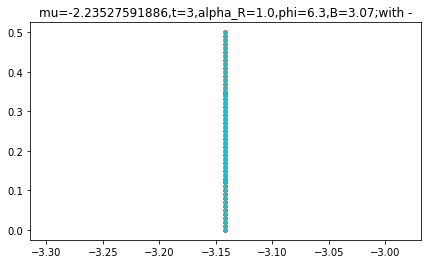

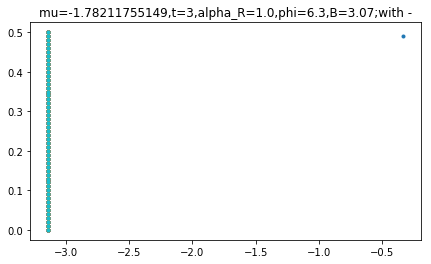

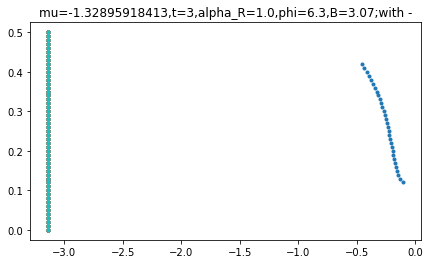

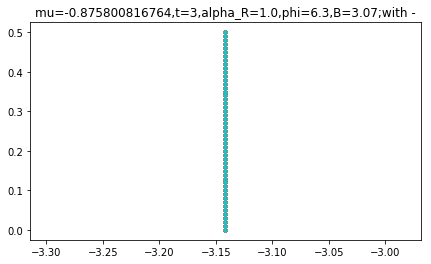

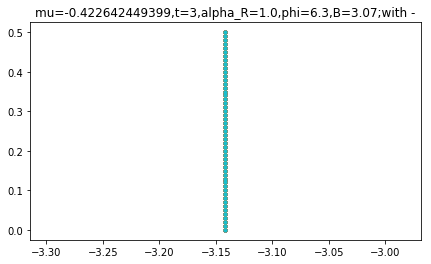

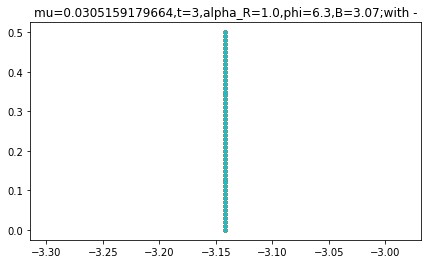

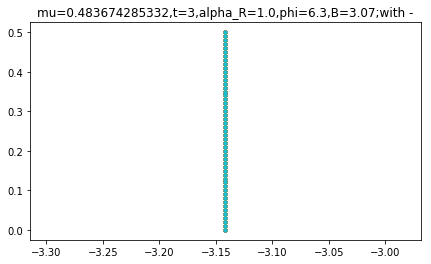

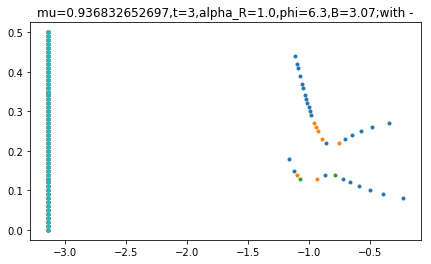

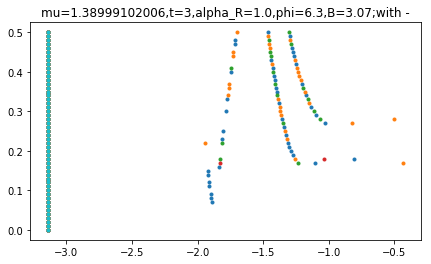

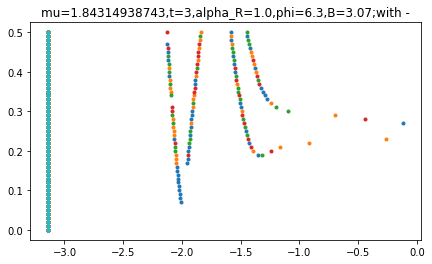

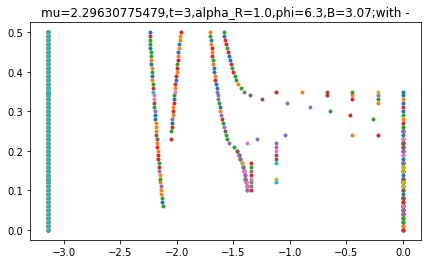

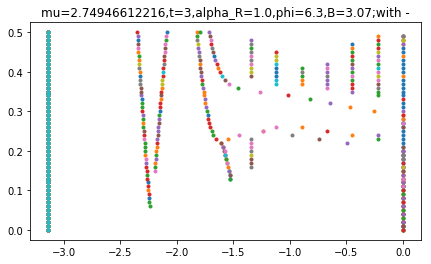

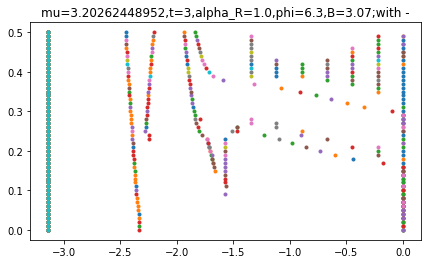

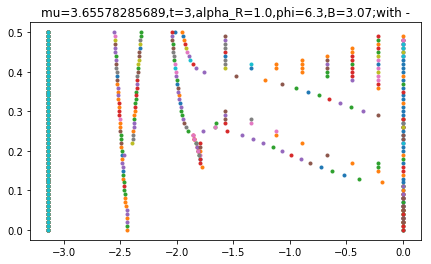

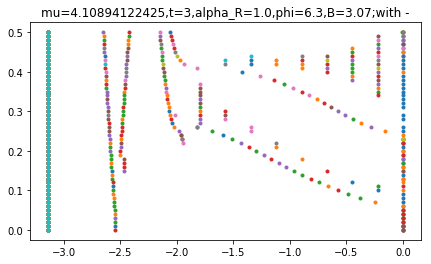

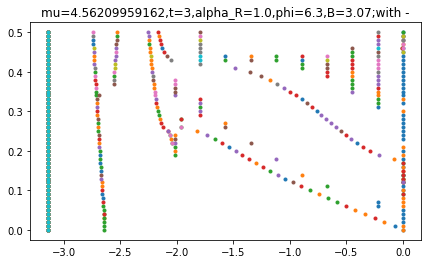

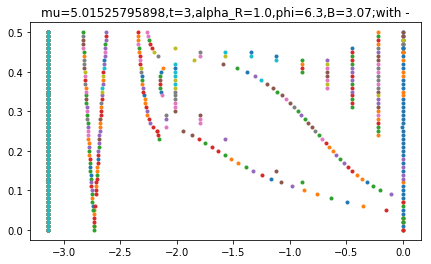

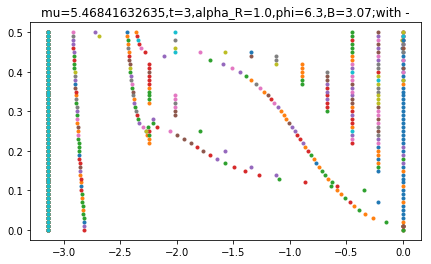

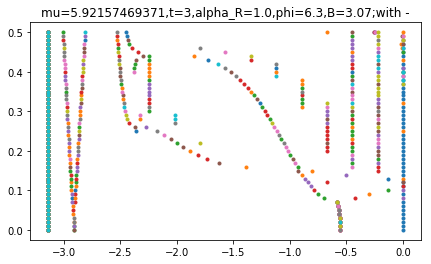

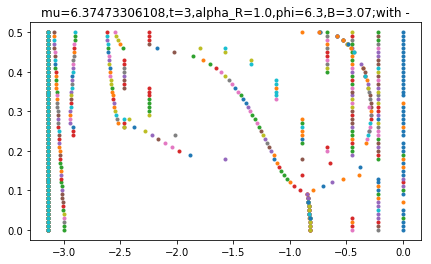

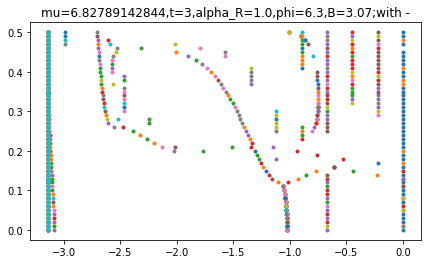

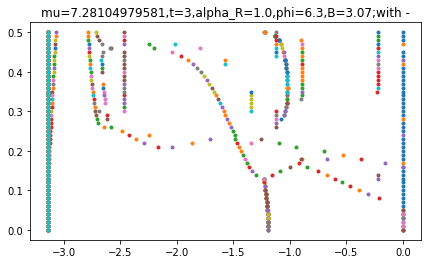

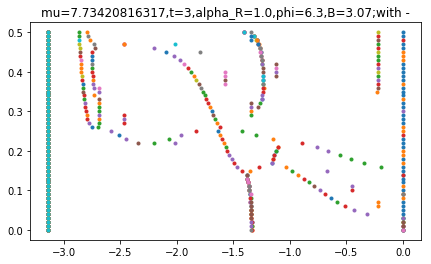

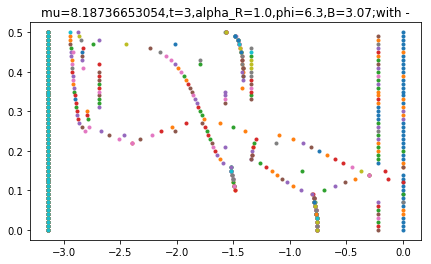

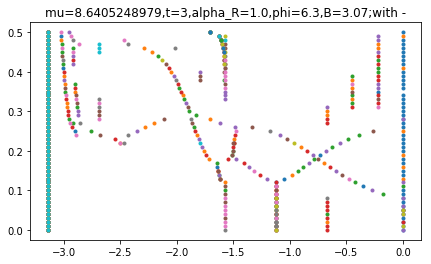

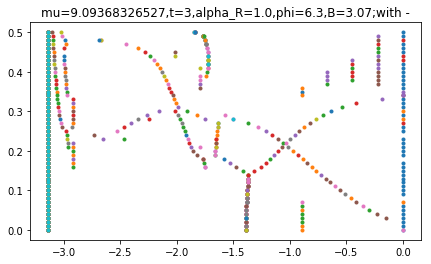

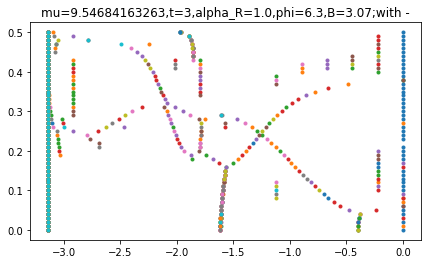

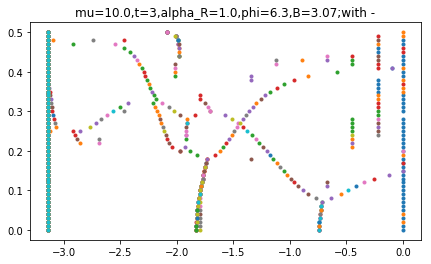

In [222]:
for l in range(len(SpecBvarOfTheFollowingGraphs2)):
    EJdisp=SpecBvarOfTheFollowingGraphs2[l]
    pp.figure(figsize=(7,4))
    for p in range(len(EJdisp[1])):
        pp.plot(EJdisp[:,p],Earray,'.')
    #pp.axis([-1.7,-1.35,-delta-0.1,delta+0.1])
    pp.title('mu={},t={},alpha_R={},phi={},B={};with -'.format(Barray[l],t,alR,round(phi,2),B))

SpecBvarOfTheFollowingGraphs1=SpecBvar

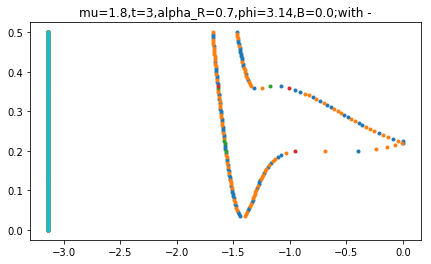

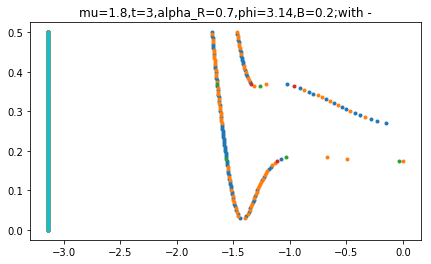

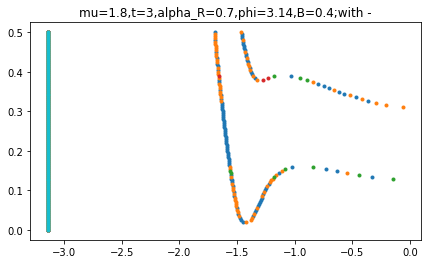

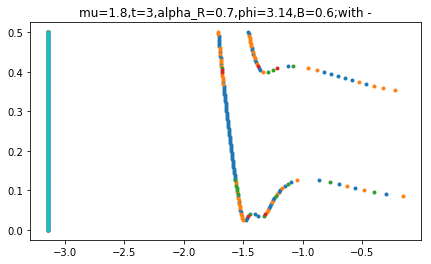

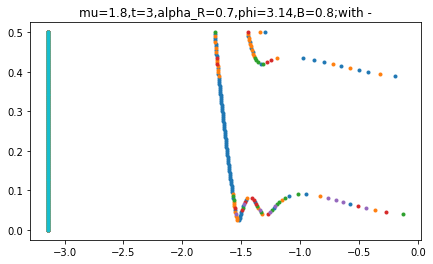

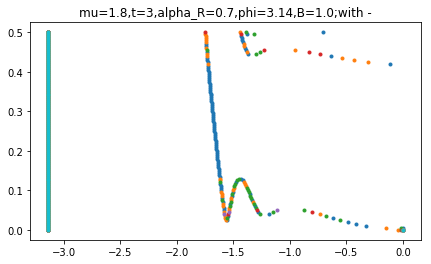

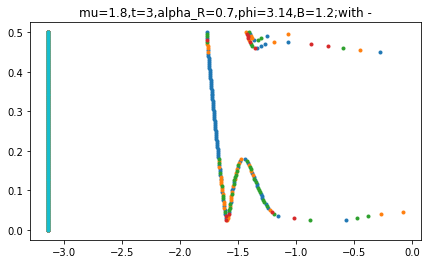

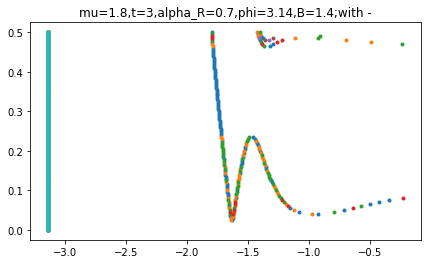

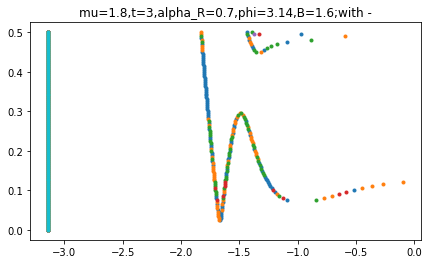

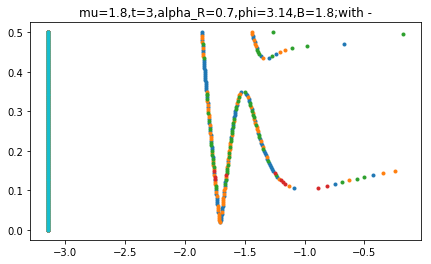

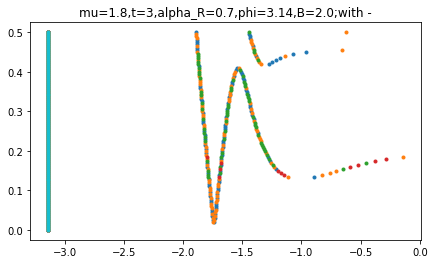

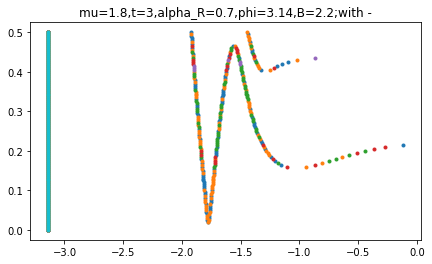

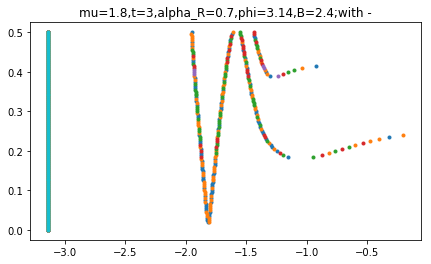

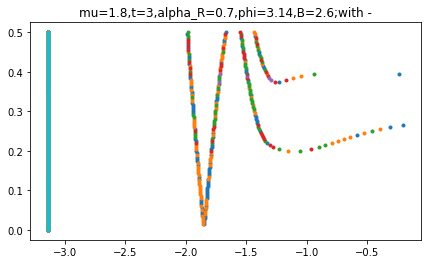

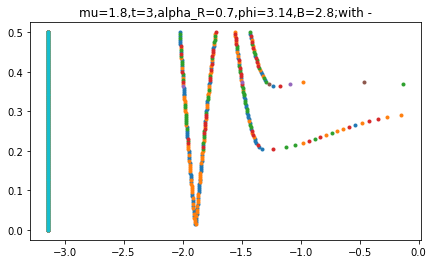

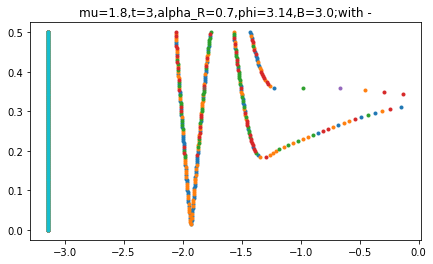

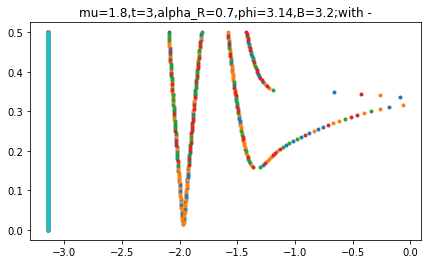

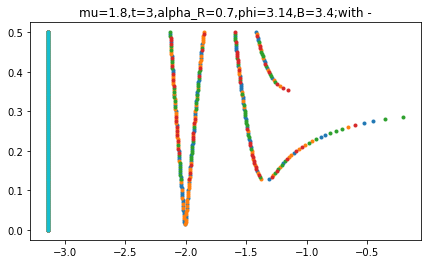

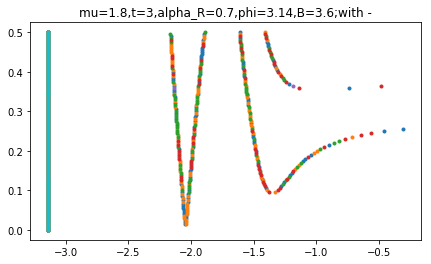

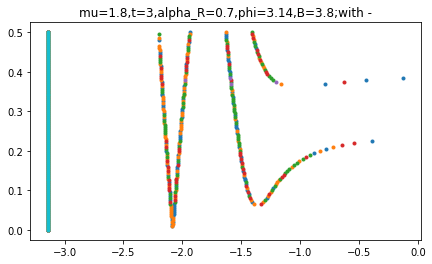

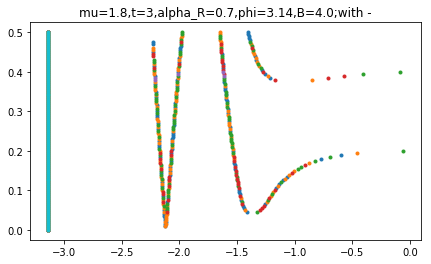

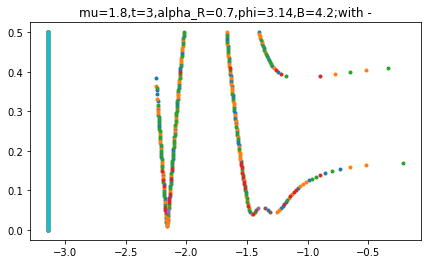

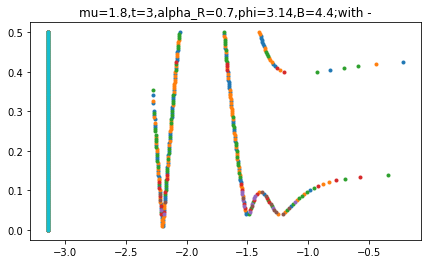

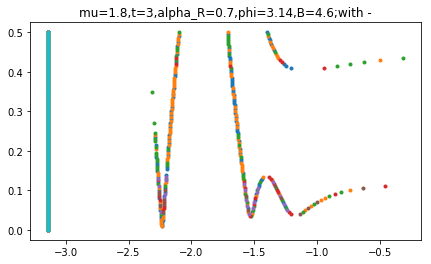

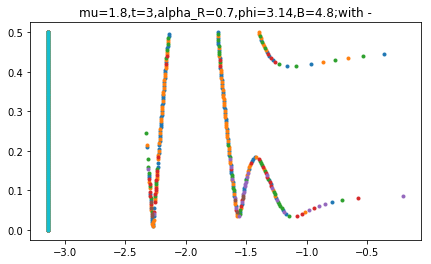

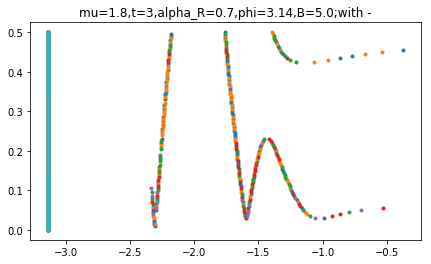

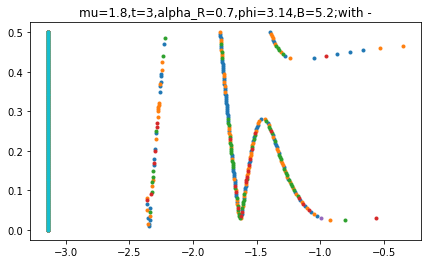

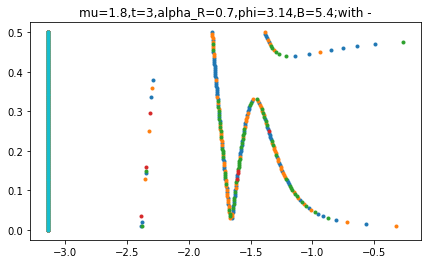

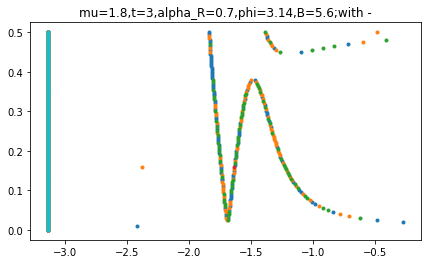

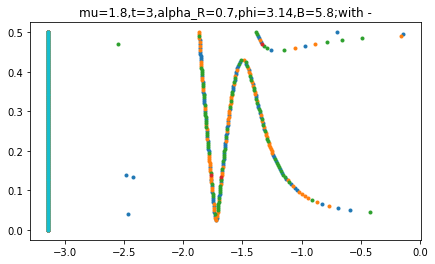

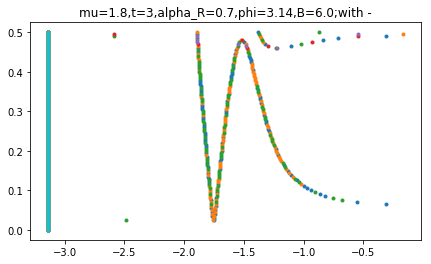

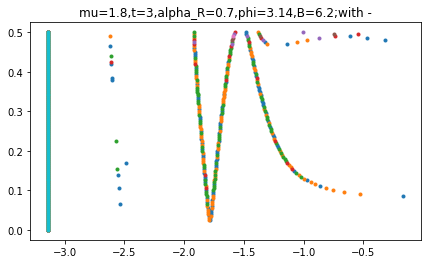

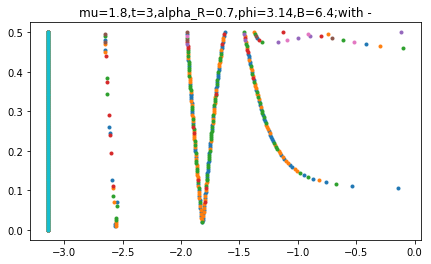

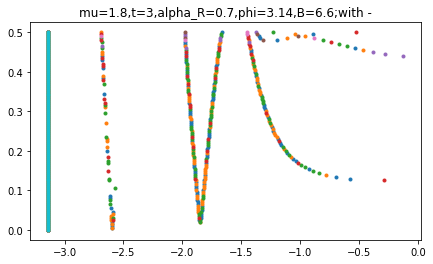

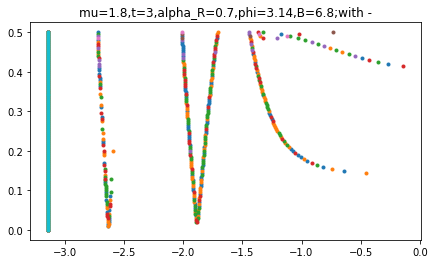

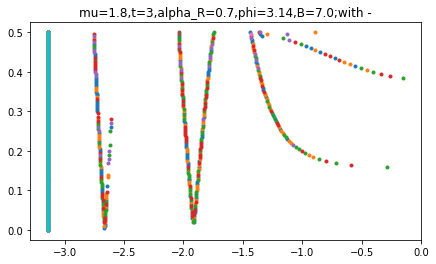

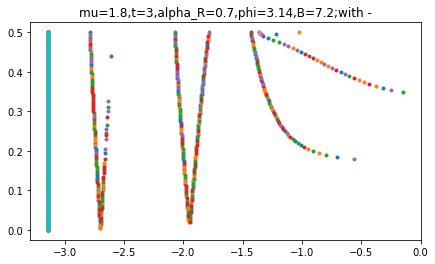

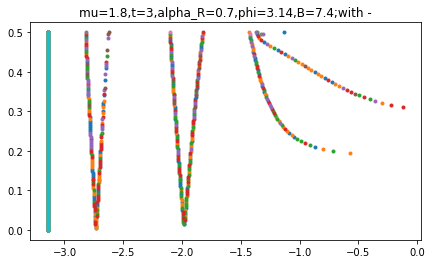

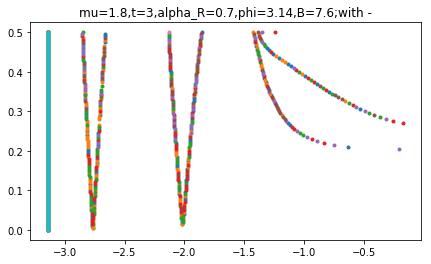

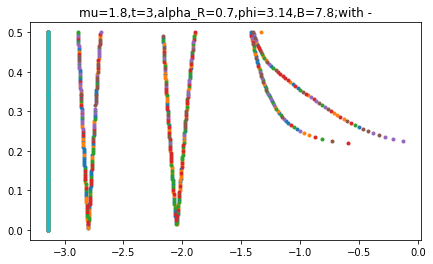

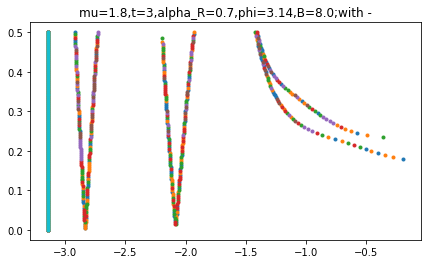

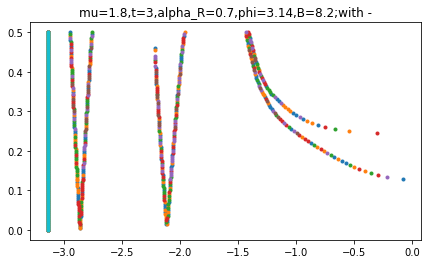

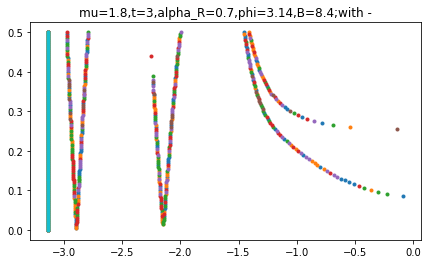

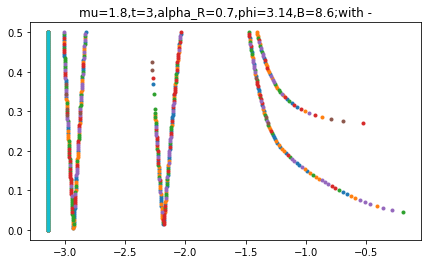

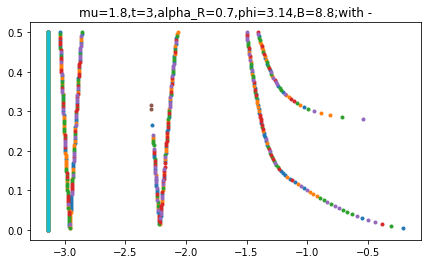

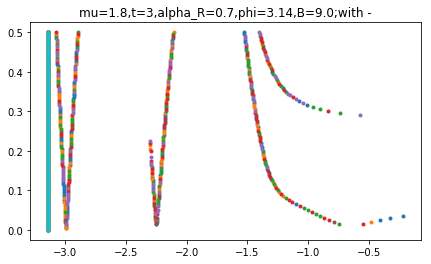

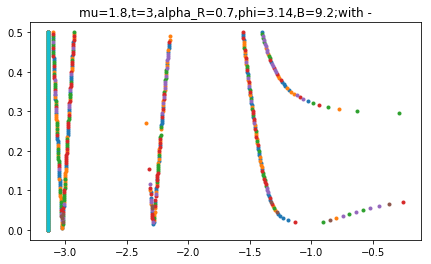

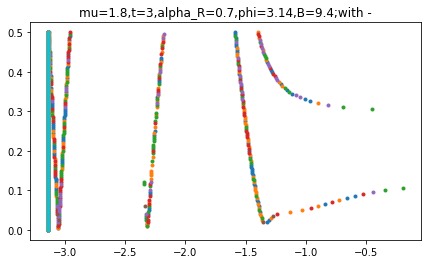

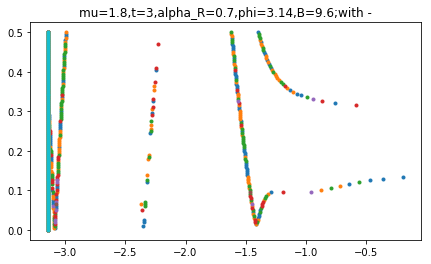

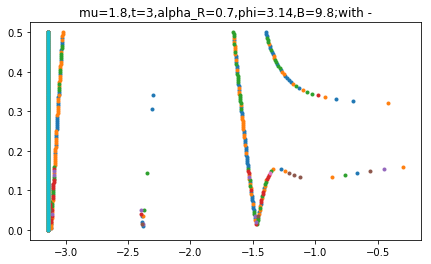

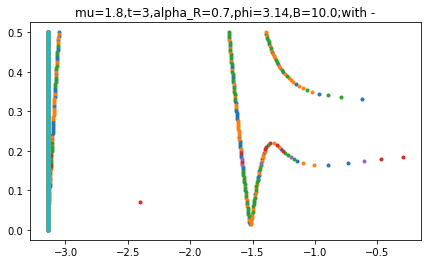

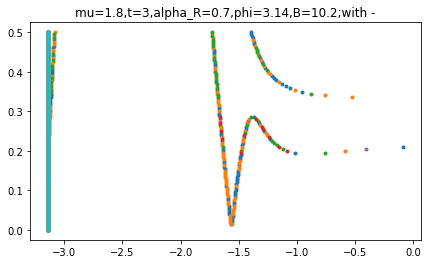

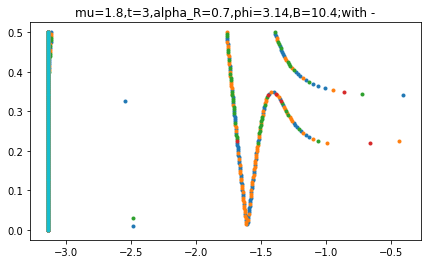

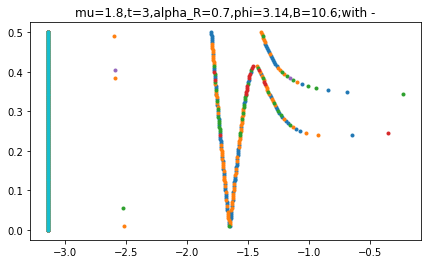

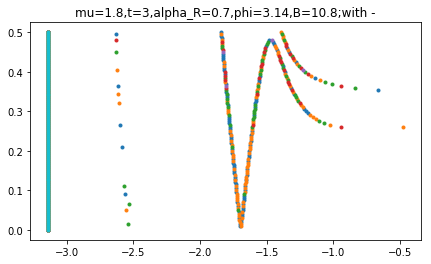

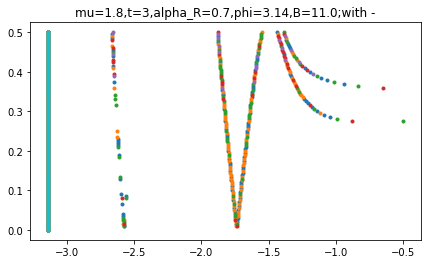

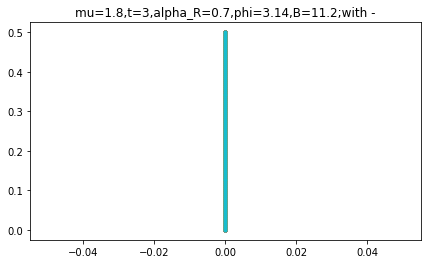

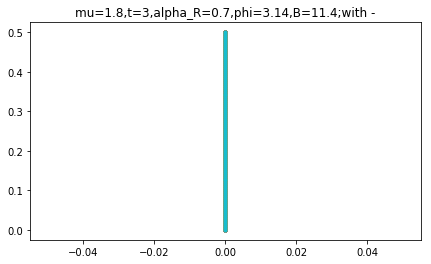

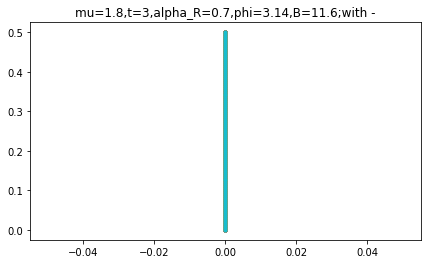

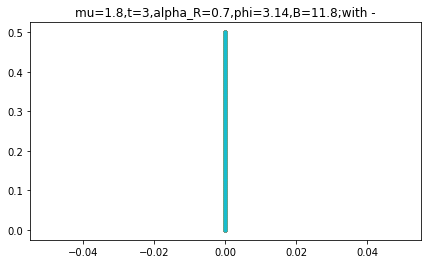

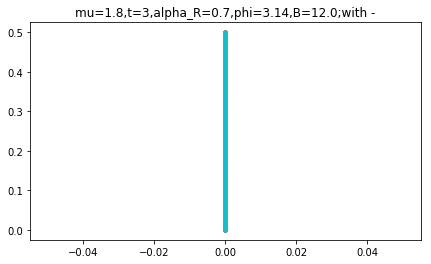

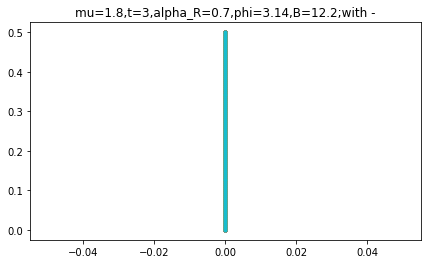

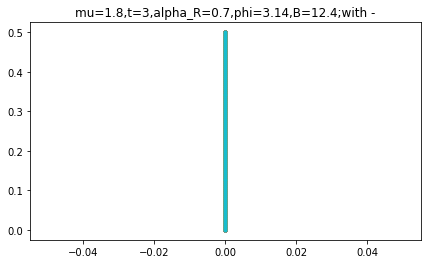

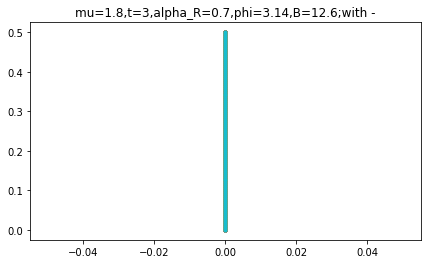

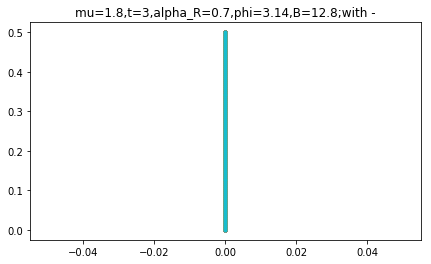

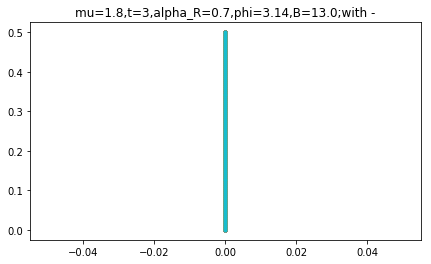

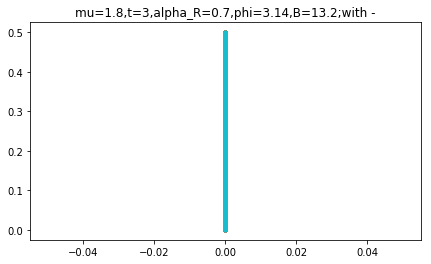

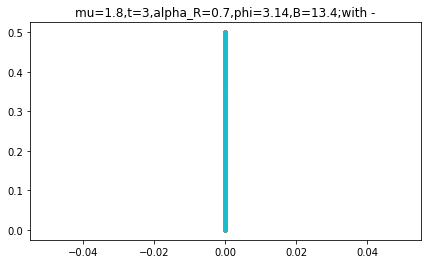

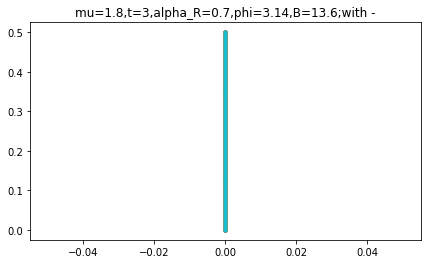

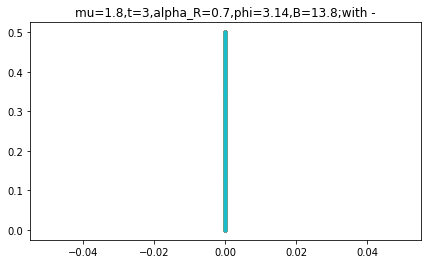

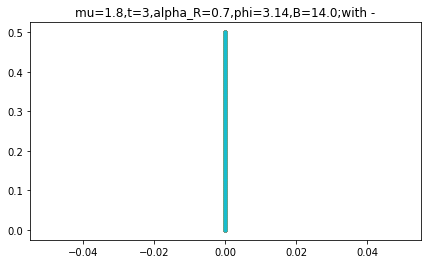

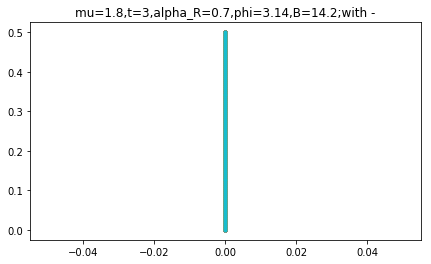

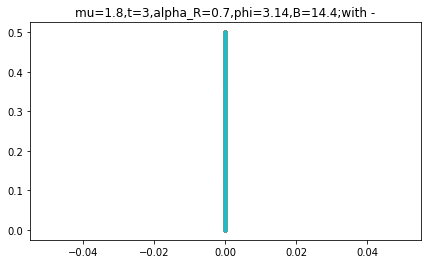

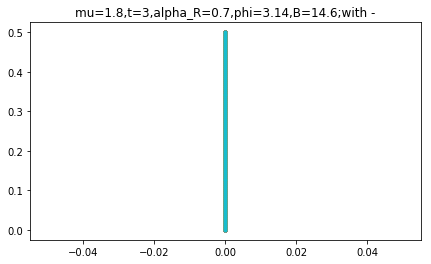

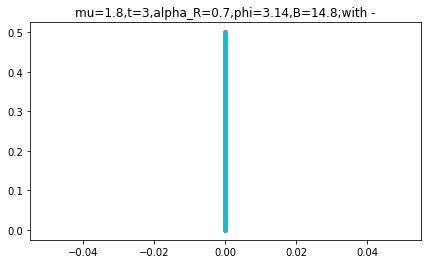

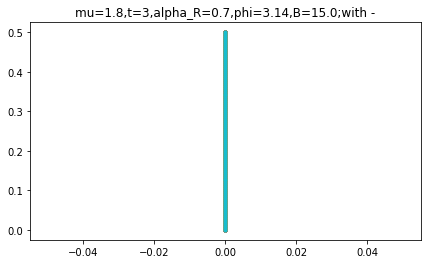

In [181]:
for l in range(len(SpecBvarOfTheFollowingGraphs1)):
    EJdisp=SpecBvarOfTheFollowingGraphs1[l]
    pp.figure(figsize=(7,4))
    for p in range(len(EJdisp[1])):
        pp.plot(EJdisp[:,p],Earray,'.')
    #pp.axis([-1.7,-1.35,-delta-0.1,delta+0.1])
    pp.title('mu={},t={},alpha_R={},phi={},B={};with -'.format(mu,t,alR,round(phi,2),Barray[l]))

Text(0,0.5,'$E/\\Delta$')

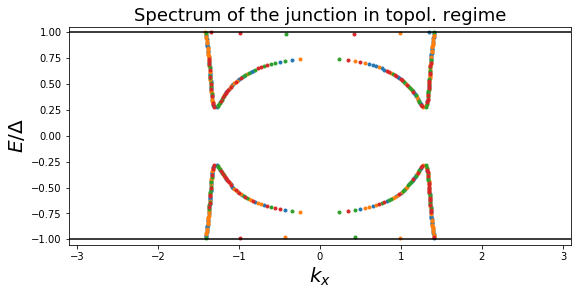

In [236]:
pp.figure(figsize=(9,4))
for p in range(len(EJdisp[1])):
    pp.plot(EJdisp[:,p],Earray/delta,'.')
pp.axis([-3.1,3.1,-1.05,1.05])
pp.plot([-np.pi,np.pi],[1,1],'k')
pp.plot([-np.pi,np.pi],[-1,-1],'k')
#pp.plot([-np.pi,np.pi],[0.27,0.27],'k')
pp.title('Spectrum of the junction in topol. regime',fontsize=18)
pp.xlabel('$k_x$',fontsize=20)
pp.ylabel('$E/\Delta$',fontsize=20)